In [ ]:
## load the packages

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import hydrant.topology.river_graph as rg
import subprocess
import os


In [2]:
# set the path to MERIT-Basins

In [3]:
# input paths
mb_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
rv_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'

# output paths
path_out = '/home/shg096/scratch/Bow_at_Calgary/domain/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)

In [4]:
# preparing the target pfaf areas for manupulation

In [5]:
pfafs = ['71', '72']

# Define the file name templates with a placeholder *
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

cat_files = []
riv_files = []

for pafaf in pfafs:
    # Replace * with the current pafaf value
    cat_files.append(cat_file_template.replace('*', pafaf))
    riv_files.append(riv_file_template.replace('*', pafaf))

# reading in data and append
cat = pd.concat([gpd.read_file(os.path.join(mb_path, f)) for f in cat_files])
riv = pd.concat([gpd.read_file(os.path.join(rv_path, f)) for f in riv_files])

cat.set_crs(epsg=4326, inplace=True, allow_override=True)
riv.set_crs(epsg=4326, inplace=True, allow_override=True)


,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,geometry
0,71000001,7.020492,4.158236,1.688334,0.000570,391.901537,2,0.0,0.000000,71000065,2,71000095,71000213,0,0,"LINESTRING (-98.06167 60.00000, -98.06250 59.9..."
1,71000002,24.171249,15.709184,1.538670,0.000058,701.754912,2,1.4,0.000058,71000065,2,71000003,71000014,0,0,"LINESTRING (-98.06167 60.00000, -98.06083 60.0..."
2,71000003,14.760464,11.209022,1.316838,0.000770,480.760660,2,11.4,0.000770,71000002,2,71000004,71000011,0,0,"LINESTRING (-98.17250 60.13000, -98.17333 60.1..."
3,71000004,6.240078,4.631999,1.347168,0.000911,388.938962,2,5.7,0.000911,71000003,2,71000005,71000015,0,0,"LINESTRING (-98.33500 60.07000, -98.33583 60.0..."
4,71000005,4.462477,3.338111,1.336827,0.000670,328.557527,2,3.0,0.000670,71000004,2,71000006,71000012,0,0,"LINESTRING (-98.39917 60.09667, -98.40000 60.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59785,72059786,8.235011,6.125759,1.344325,0.008896,51.578512,1,73.3,0.008896,72057890,0,0,0,0,0,"LINESTRING (-81.56917 41.20250, -81.57000 41.2..."
59786,72059787,0.881055,0.648637,1.358317,0.000000,28.659389,1,0.0,0.000000,72058076,0,0,0,0,0,"LINESTRING (-84.77500 41.24333, -84.77417 41.2..."
59787,72059788,0.001115,0.001115,1.000000,0.000000,28.138533,1,0.0,0.000000,0,0,0,0,0,0,"LINESTRING (-72.38500 61.88750, -72.38500 61.8..."
59788,72059789,0.001111,0.001111,1.000000,10.799241,26.348979,1,0.0,0.000000,0,0,0,0,0,0,"LINESTRING (-55.38917 47.21667, -55.38917 47.2..."


## Example-1 From West

In [6]:
# data creation, Station ID, seg ID that accompany the station, Station name,
# and up flag meaning is the flow should be sum of upstream segmenets
# this can be created in a csv file and be read here.

data = {
    'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
    'seg ID': [71028039, 71027942, 71034975, 71022153],
    'Station name': [
        'BOW RIVER NEAR SEEBE',
        'BOW RIVER AT CALGARY',
        'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
        'RED DEER RIVER AT RED DEER'
    ],
    'up': [0, 0, 0, 0]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

In [7]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.intersect_topology(cat=cat,\
                                             cat_cols={'id':'COMID'},\
                                             riv=riv,\
                                             riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                             outlet_id=list(stations_seg_id['seg ID']))


stations = gpd.read_file('../../data/stations_point/stations_point.shp')
stations_sliced = stations[stations['Station ID'].isin(list(stations_seg_id['Station ID']))]

<AxesSubplot:>

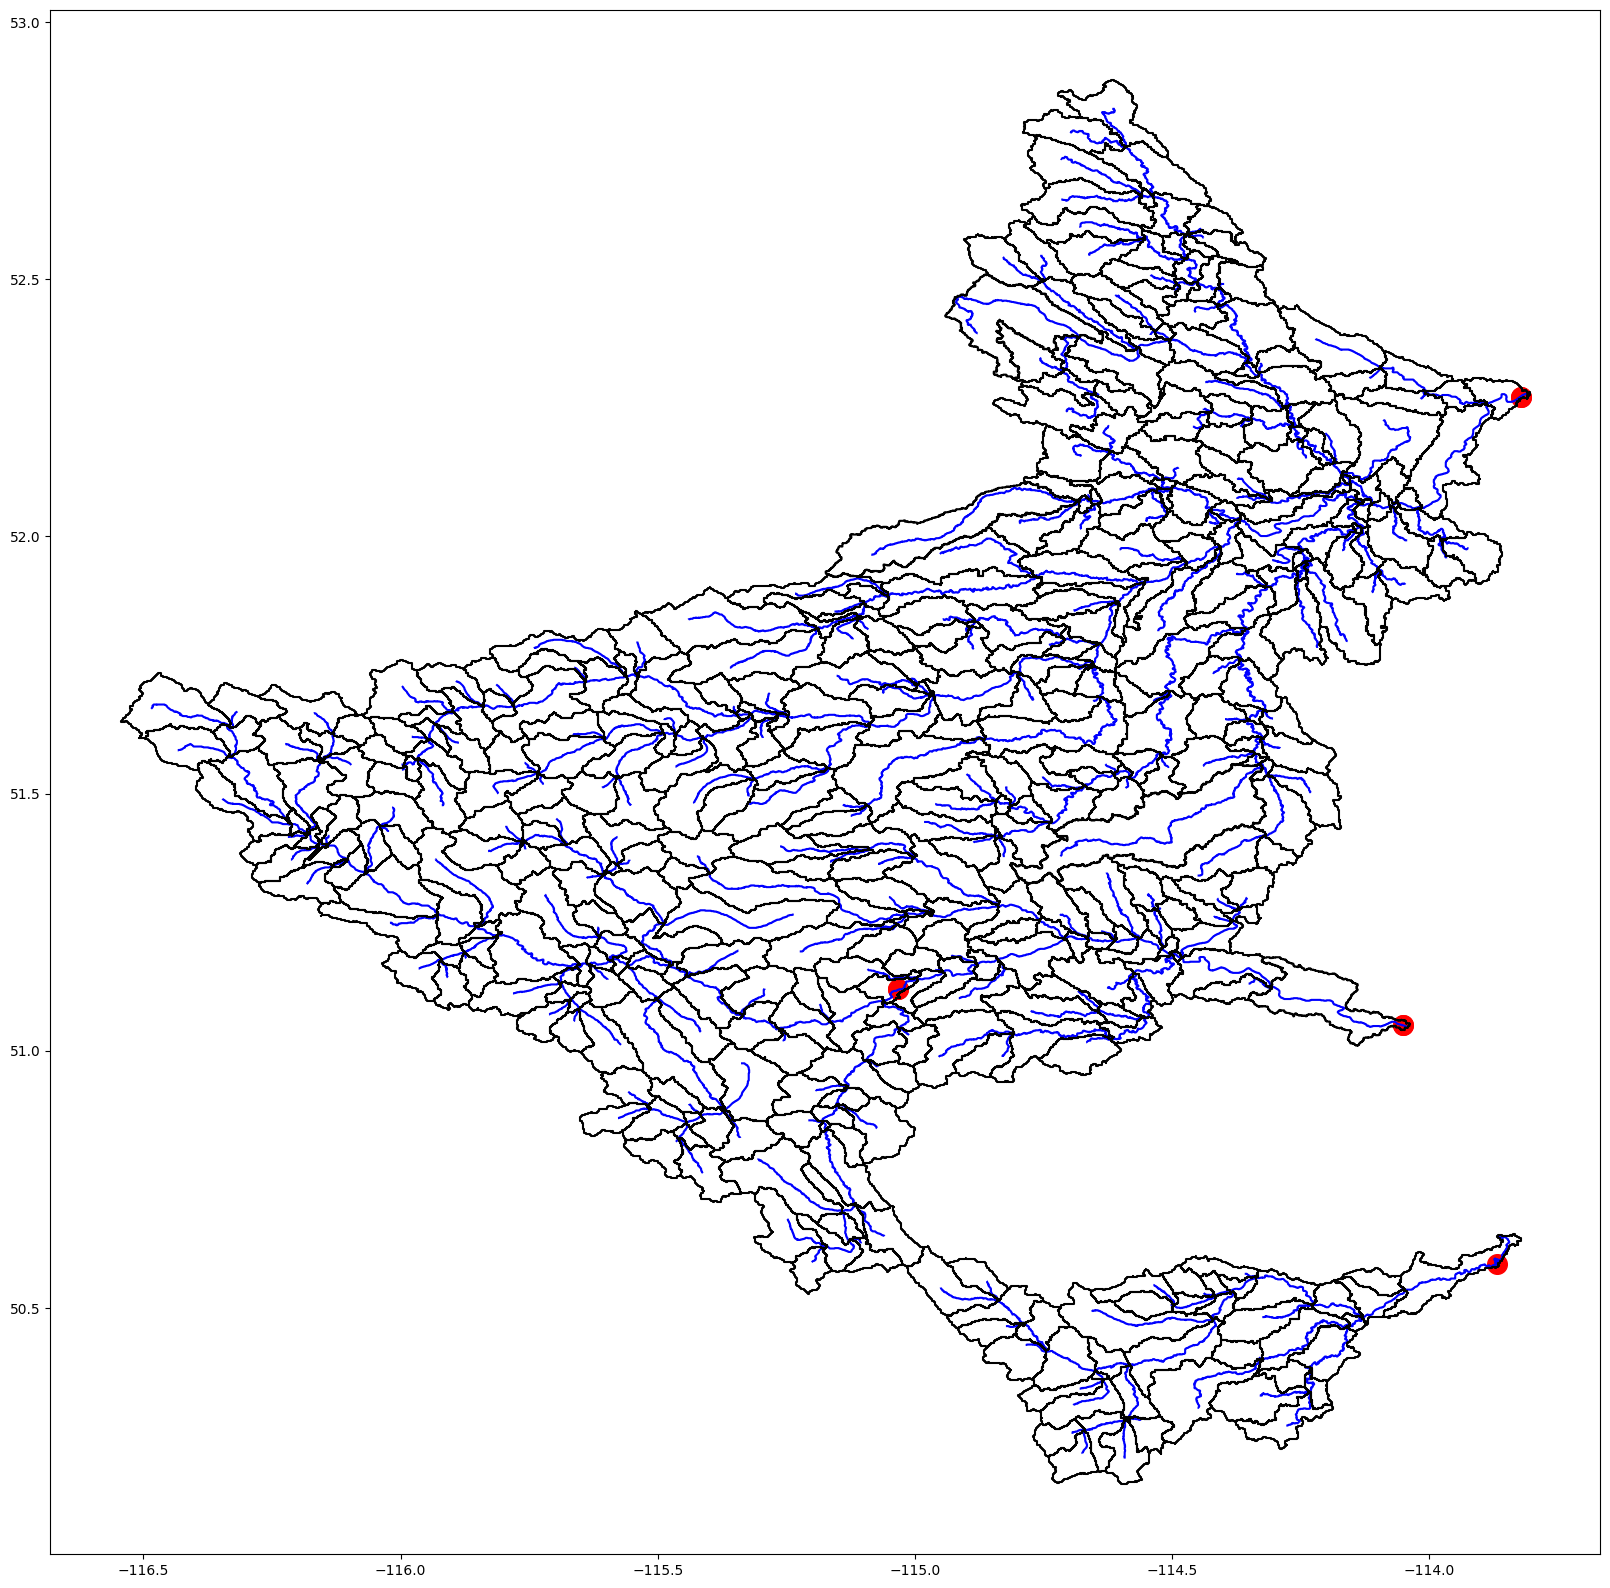

In [8]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_sliced.plot(ax=ax, color='r', markersize=200)

In [9]:
cat_slice.to_file(path_out+'Bow_at_Calgary_cat.shp')
riv_slice.to_file(path_out+'Bow_at_Calgary_riv.shp')

## Example-2 From West

In [9]:
# data creation, Station ID, seg ID that accompany the station, Station name,
# and up flag meaning is the flow should be sum of upstream segmenets
# this can be created in a csv file and be read here.

data = {
    'Station ID': ['02HC013', '02HC018', '02EC011', '02HC024'],
    'seg ID': [72052687, 72052485, 72051928, 72055140],
    'Station name': [
        'HIGHLAND CREEK NEAR WEST HILL',
        'LYNDE CREEK NEAR WHITBY',
        'BEAVERTON RIVER NEAR BEAVERTON',
        'DON RIVER AT TODMORDEN'
    ],
    'up': [1, 1, 1, 1]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

In [10]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.intersect_topology(cat=cat,\
                                             cat_cols={'id':'COMID'},\
                                             riv=riv,\
                                             riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                             outlet_id=list(stations_seg_id['seg ID']))


stations = gpd.read_file('../../data/stations_point/stations_point.shp')
stations_sliced = stations[stations['Station ID'].isin(list(stations_seg_id['Station ID']))]

<AxesSubplot:>

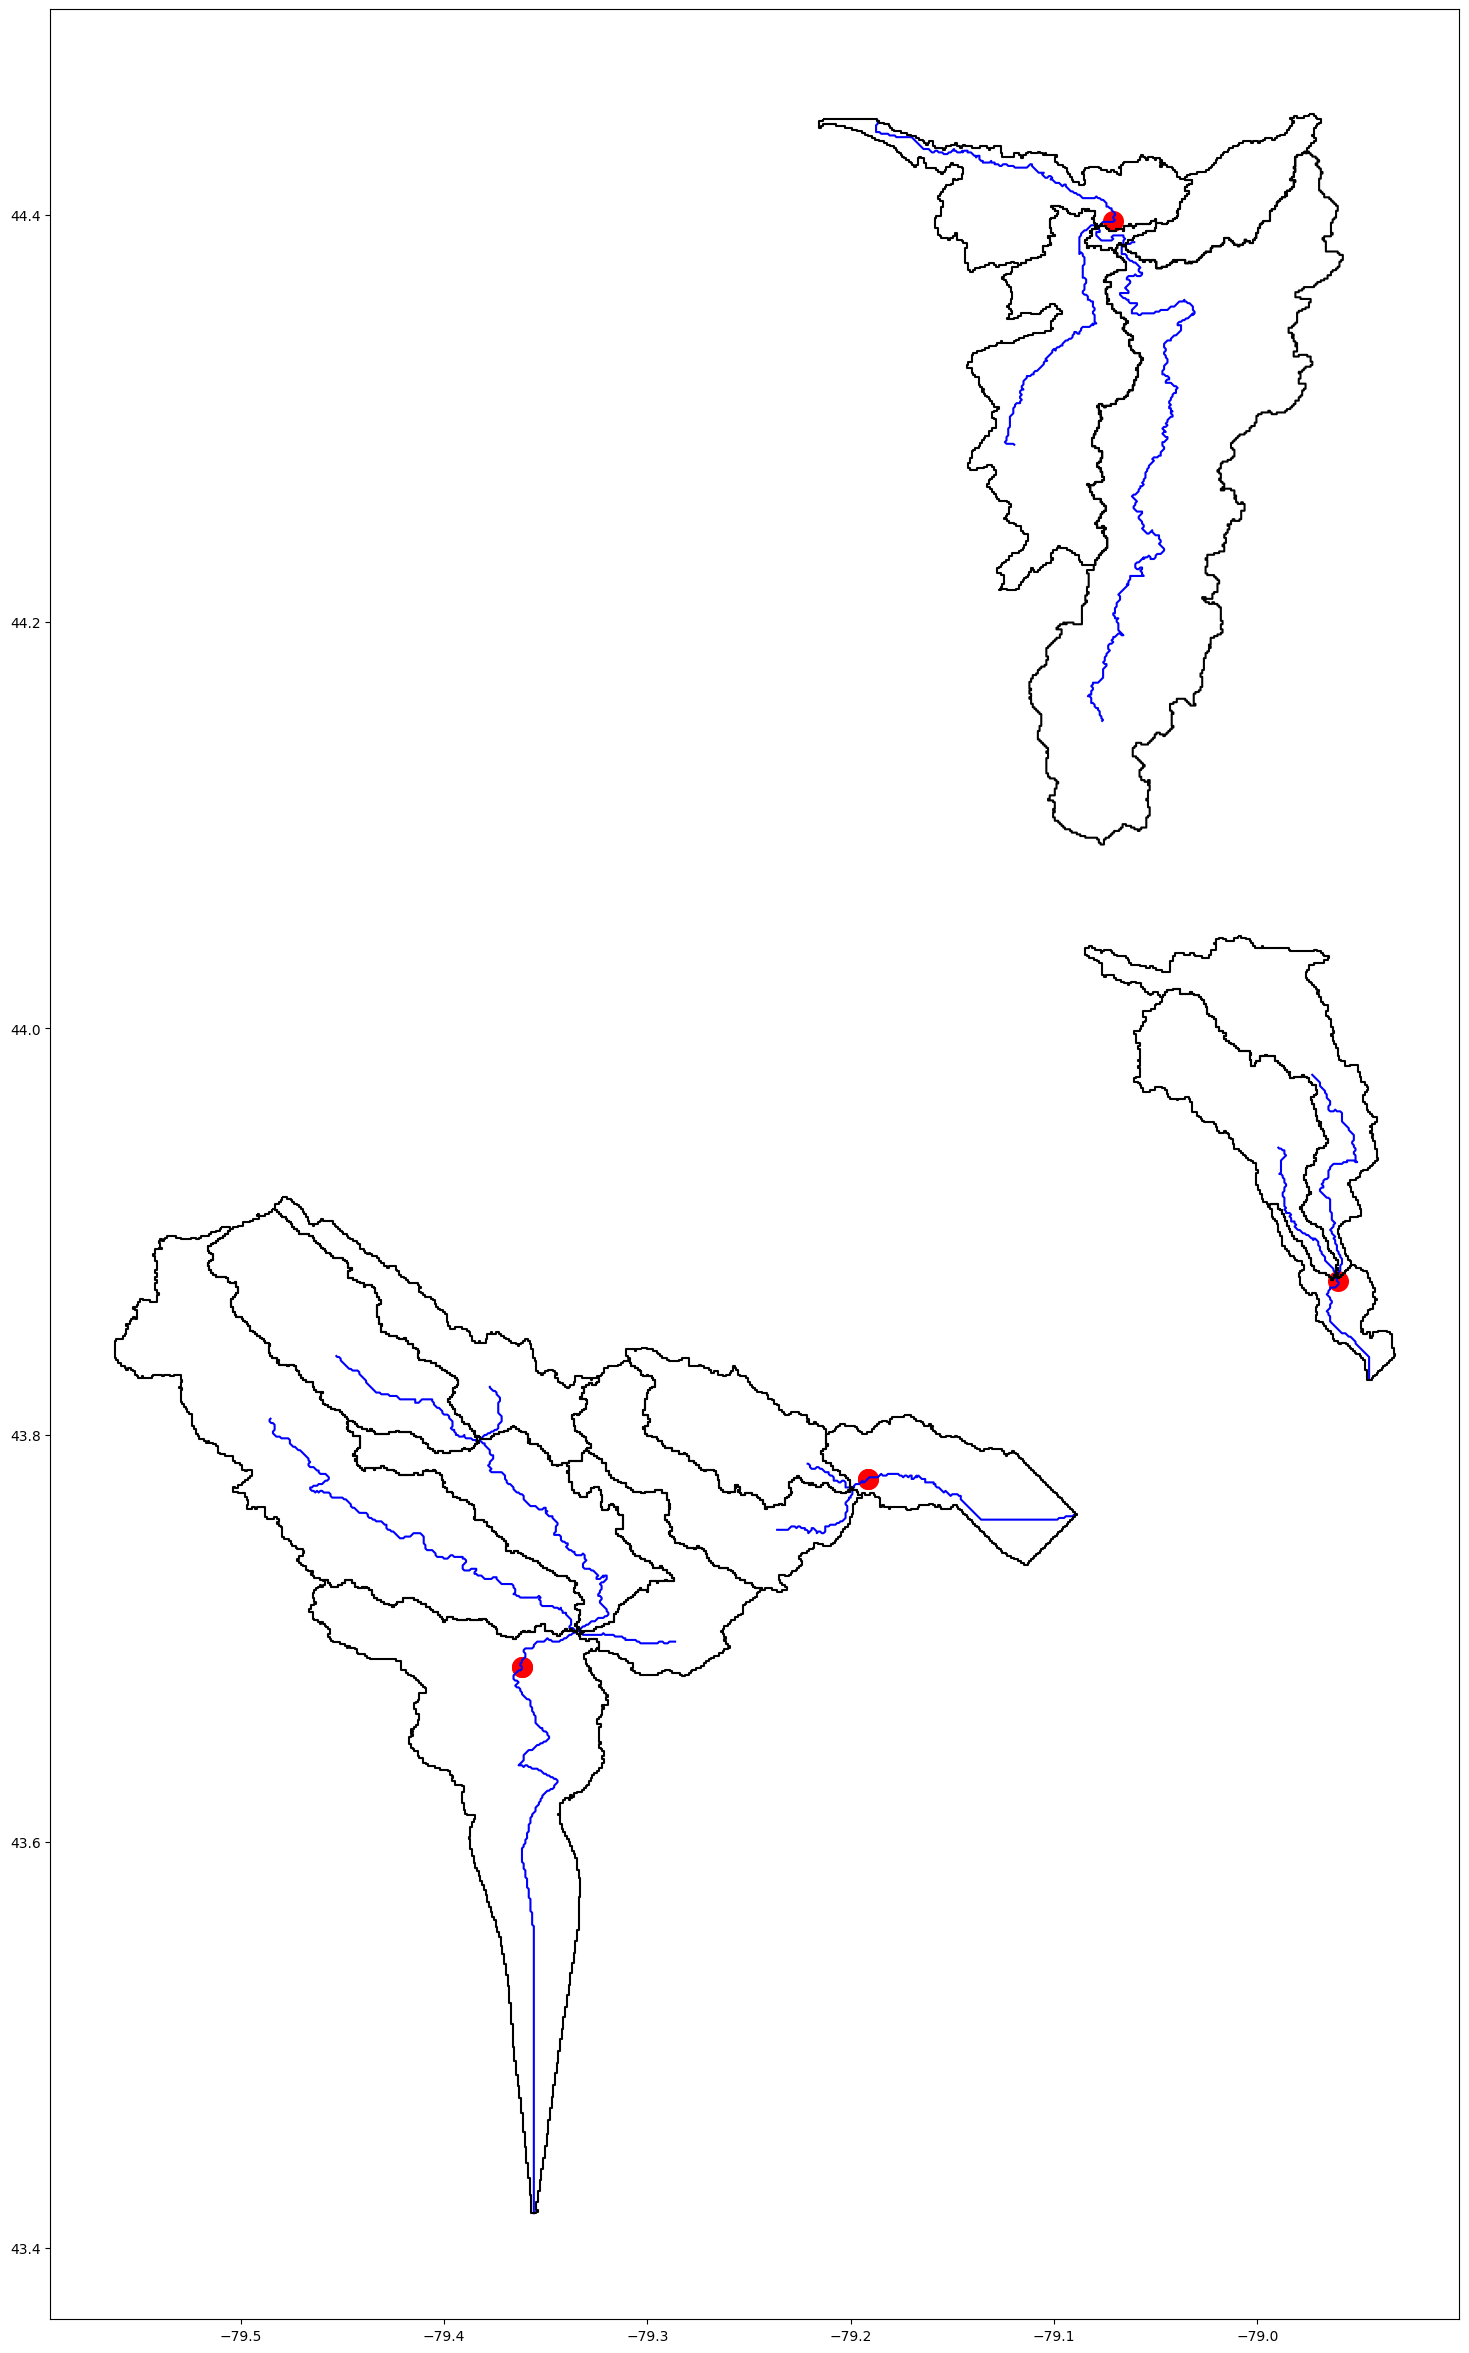

In [11]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_sliced.plot(ax=ax, color='r', markersize=200)

In [ ]:
# # Manupulate target shapefile if desired or exists (this is optional)
# trg_shp = gpd.read_file('../../data/province/provinces.shp')
# sel_pr = ['Quebec', 'New Brunswick', 'Nova Scotia', 'Prince Edward Island']
# sel_pr = ['Nova Scotia', 'Prince Edward Island']
# sel_pr = ['Alberta']
# # subsetting `provinces` variable
# trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)
# trg_provinces.boundary.plot(color='k')

In [ ]:
# cat, riv = gm.intersect_topology(cat=cat,\
#                                  cat_cols={'id':'COMID'},\
#                                  riv=riv,\
#                                  riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
#                                  shapefile=trg_provinces)



In [ ]:
# fig, ax = plt.subplots(figsize=(20,30))
# trg_provinces.boundary.plot(ax=ax, color='k')
# cat.boundary.plot(ax=ax,color='k')
# riv.plot(ax=ax,color='blue')

In [ ]:
# def get_segment(riv,
#                 station_info,
#                 riv_col_seg,
#                 station_col_name = {'lat':'lat', 'lon':'lon', 'up_area':'up_area'},
#                 riv_col_up_area = None,
#                 riv_scale_up_area = None, # km2 to m2
#                 station_scale_up_area = None, # km2 to m2
#                 tolerance_for_area_diff = 0.05):

#     # 
#     if riv_col_up_area is not None:
#         if riv_scale_up_area is not None:
#             riv[riv_col_up_area] = riv[riv_col_up_area]*riv_scale_up_area

#     # rename station
#     station_info = station_info.rename(columns = station_col_name)
#     print(station_info)

#     if station_scale_up_area is not None:
#         station_info.loc ['up_area'] = station_info.loc ['up_area'] * station_scale_up_area

#     # 
#     riv['lat_centroid'] = riv.centroid.y
#     riv['lon_centroid'] = riv.centroid.x

#     station_info['seg_id'] = np.NaN
#     # loop over the station_info get the lat and lon and if available upstream area
#     for index, row in station_info.iterrows():
#         print(row)
#         riv_temp = riv.copy()
#         riv_temp['dist'] = 0
#         riv_temp['dist'] = (riv['lat_centroid']-row['lat'])**2 + (riv['lon_centroid']-row['lon'])**2
#         if (tolerance_for_area_diff is not None) and (riv_col_up_area is not None) and ('up_area' in station_col_name.keys()):
#             riv_temp['area_within'] = riv_temp[riv_col_up_area].abs()/row.up_area.item()
#             riv_temp = riv_temp [riv_temp ['area_within'] < tolerance_for_area_diff]
#         if not riv_temp.empty: # pass Nan
#             riv_temp = riv_temp.sort_values(by='dist')
#             riv_temp = riv_temp.reset_index(drop=True)
#             station_info['seg_id'].iloc[index] = riv_temp[riv_col_seg].iloc[0]

#     return station_info
        

In [ ]:
# station_info = pd.read_csv('../../data/stations/Bow_at_Calagary.csv')

# print(station_info)

# station_info = get_segment(riv,
#                 station_info,
#                 'COMID',
#                 station_col_name = {'Latitude':'lat', 'Longitude':'lon'},
#                 riv_col_up_area = None,
#                 riv_scale_up_area = None, # km2 to m2
#                 station_scale_up_area = None, # km2 to m2
#                 tolerance_for_area_diff = 0.05)